In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm
import astropy.units as u
import gala.potential as gp
from gala.units import galactic
from astropy.constants import G

from stream_evolution_potential import NFW, Plummer, run, LeepFrog_Coupled_all, phase

In [2]:
### First define the Halo and Progenitor ###

halo_mass     = 7.5e11 * u.M_sun
concentration = 20.
flattening_xy  = 1.
flattening_xz  = 1.

halo = NFW(halo_mass, concentration, flattening_xy, flattening_xz)

progenitor_mass = 6.48e8 * u.M_sun # M_sun
alpha = 0.85 * u.kpc # kpc
progenitor = Plummer(progenitor_mass,alpha) 

In [58]:
progenitor.__init__(progenitor_mass,alpha)

In [59]:
progenitor.M

<Quantity 6.48e+08 solMass>

In [13]:
def angular_velocity(x,y,z,vx,vy,vz):
    
    r = np.sqrt(x**2+y**2+z**2) 
    r_vect = np.array([x.value,y.value,z.value])*u.kpc 
    v_vect = np.array([vx.value,vy.value,vz.value])*u.km/u.s 
    L_vect = np.cross(r_vect, v_vect)
    L = np.linalg.norm(L_vect)

    return (L/r**2).to(1/u.Gyr)
    
def r_t_Gibbons(x,y,z,vx,vy,vz,M, halo):
    return (G.to(u.kpc**3/(u.Msun*u.Gyr**2)) * M.to(u.Msun) / (angular_velocity(x,y,z,vx,vy,vz)**2 - halo.second_derivative_potential(x,y,z).to(1/u.Gyr**2)) )**(1/3)

def r_t(rp,halo,progenitor):
    return rp * (progenitor.mass_enclosed(rp) / (3*halo.mass_enclosed(rp)) )**(1/3)

In [52]:
t_start, t_end, dt = 0, 4, 1e-3 # Gyr
pos_prog = [60, -60, 10] # kpc

pos_scat = [0, 0, 0] # kpc


vel_prog = [0, 100, 0] # km/s
vel_scat = [0, 0, 0] #km/s
N = 2 # amount of star ejected per dt

# def run(t_start, t_end, dt, halo, progenitor, pos_prog, vel_prog, vel_scat, N):

time    = np.arange(t_start + dt, t_end + dt, dt)

xp, yp, zp    = pos_prog[0] * u.kpc, pos_prog[1] * u.kpc, pos_prog[2] * u.kpc # kpc

vxp, vyp, vzp = vel_prog[0] * u.km/u.s, vel_prog[1] * u.km/u.s, vel_prog[2] * u.km/u.s # km/s
vx_scatter, vy_scatter, vz_scatter = vel_scat[0] * u.km/u.s, vel_scat[1] * u.km/u.s, vel_scat[2] * u.km/u.s # km/s

all_pos_p = np.zeros([3, len(time)+2]) * u.kpc
all_vel_p = np.zeros([3, len(time)+2]) * u.km/ u.s
all_pos_p[:,0] = [xp,yp,zp] 
all_vel_p[:,0] = [vxp,vyp,vzp]

all_pos_N = np.zeros([3, N*len(time)+2]) * u.kpc
all_vel_N = np.zeros([3, N*len(time)+2]) * u.km/u.s
all_xhi_N = np.zeros([1, N*len(time)+2]) * u.kpc

save_all_pos_N = np.zeros([3, len(time)+1, N*len(time)+2]) * u.kpc
save_all_vel_N = np.zeros([3, len(time)+1, N*len(time)+2]) * u.km/u.s
save_all_xhi_N = np.zeros([1, len(time)+1, N*len(time)+2]) * u.kpc

all_rt = np.zeros(len(time)+1) * u.kpc
all_L1 = np.zeros([3,len(time)+1]) * u.kpc
all_L2 = np.zeros([3,len(time)+1]) * u.kpc

In [53]:
for t in tqdm(range(len(time)+1), leave=True):

    r_prog = np.sqrt(xp**2+yp**2+zp**2)
    rt = r_t_Gibbons(xp,yp,zp,vxp,vyp,vzp,progenitor_mass, halo)*1.5

    all_rt[t] = rt
    theta  = np.arccos(zp/r_prog)
    phi    = np.arctan2(yp,xp)
    xt1, yt1, zt1 = (r_prog - rt)*np.sin(theta)*np.cos(phi), (r_prog - rt)*np.sin(theta)*np.sin(phi), (r_prog - rt)*np.cos(theta)
    xt2, yt2, zt2 = (r_prog + rt)*np.sin(theta)*np.cos(phi), (r_prog + rt)*np.sin(theta)*np.sin(phi), (r_prog + rt)*np.cos(theta)

    all_L1[:,t] = [xt1, yt1, zt1]
    all_L2[:,t] = [xt2, yt2, zt2]

    xN_L1, yN_L1, zN_L1    = xt1.value*torch.ones(N//2), yt1.value*torch.ones(N//2), zt1.value*torch.ones(N//2)
    xN_L2, yN_L2, zN_L2    = xt2.value*torch.ones(N - N//2), yt2.value*torch.ones(N - N//2), zt2.value*torch.ones(N - N//2)

    xN, yN, zN    = torch.cat((xN_L1,xN_L2))*u.kpc, torch.cat((yN_L1,yN_L2))*u.kpc, torch.cat((zN_L1,zN_L2))*u.kpc
    vxN, vyN, vzN =  vxp + torch.randn(N)*vx_scatter, vyp + torch.randn(N)*vy_scatter, vzp + torch.randn(N)*vz_scatter

    all_pos_N[:,int(t*N):int((t+1)*N)] = [xN,yN,zN] 
    all_vel_N[:,int(t*N):int((t+1)*N)] = [vxN,vyN,vzN]

    xp,yp,zp,vxp,vyp,vzp,xN,yN,zN,vxN,vyN,vzN = LeepFrog_Coupled_all(halo.acceleration, 
                                                                    progenitor.acceleration,
                                                                    all_pos_N[0,:int((t+1)*N)], all_pos_N[1,:int((t+1)*N)], all_pos_N[2,:int((t+1)*N)],
                                                                    xp,yp,zp, 
                                                                    vxp,vyp, vzp,
                                                                    all_vel_N[0,:int((t+1)*N)], all_vel_N[1,:int((t+1)*N)], all_vel_N[2,:int((t+1)*N)], 
                                                                    dt * u.Gyr)
        
    # Update 
    all_pos_N[:,:int((t+1)*N)] = [xN,yN,zN] 
    all_vel_N[:,:int((t+1)*N)] = [vxN,vyN,vzN]
    all_xhi_N[:,:int((t+1)*N)] += phase(all_pos_N[0,:int((t+1)*N)],
                                    all_pos_N[1,:int((t+1)*N)],
                                    all_pos_N[2,:int((t+1)*N)],
                                    xp,yp,zp)
    
    all_pos_p[:,(t+1)] = [xp,yp,zp] 
    all_vel_p[:,(t+1)] = [vxp,vyp,vzp]

    # Save
    save_all_pos_N[:,t,:int((t+1)*N)] = all_pos_N[:,:int((t+1)*N)].copy()
    save_all_vel_N[:,t,:int((t+1)*N)] = all_vel_N[:,:int((t+1)*N)].copy()
    save_all_xhi_N[:,t,:int((t+1)*N)] = all_xhi_N[:,:int((t+1)*N)].copy()



# return time, all_pos_p.value, all_vel_p.value, save_all_pos_N.value, save_all_vel_N.value, save_all_xhi_N.value, all_rt.value, all_L1.value, all_L2.value


100%|██████████| 4001/4001 [00:19<00:00, 210.05it/s]


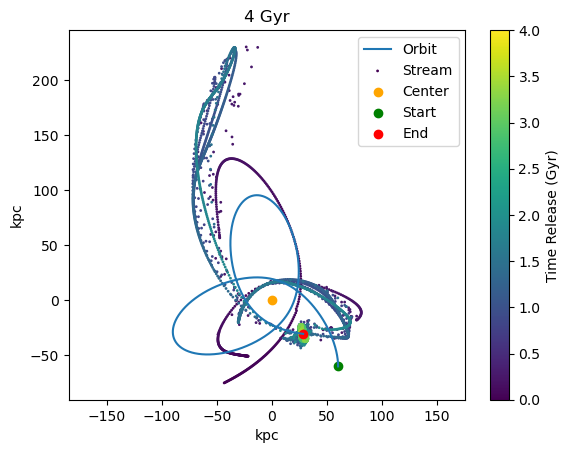

In [49]:
x = all_pos_p[0,:]
y = all_pos_p[1,:]
plt.plot(x,y, label = 'Orbit')
value_array = np.linspace(0,t_end,len(all_pos_N[1,:]))
plt.scatter(all_pos_N[0,:],all_pos_N[1,:],c=value_array, s=1, label='Stream',cmap='viridis')
plt.colorbar(label='Time Release (Gyr)')  # show color scale
plt.scatter(0,0,color='orange', label = 'Center')
plt.scatter(x[0],y[0],color='g', label = 'Start')
plt.scatter(x[-1],y[-1],color='r', label = 'End')
plt.xlabel('kpc')
plt.ylabel('kpc')
plt.title(str(t_end)+' Gyr')
plt.axis('equal')
plt.legend()

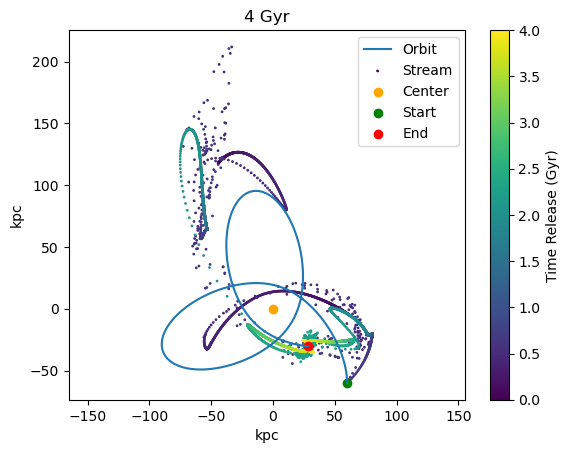

In [54]:
x = all_pos_p[0,:]
y = all_pos_p[1,:]
plt.plot(x,y, label = 'Orbit')
value_array = np.linspace(0,t_end,len(all_pos_N[1,:]))
plt.scatter(all_pos_N[0,:],all_pos_N[1,:],c=value_array, s=1, label='Stream',cmap='viridis')
plt.colorbar(label='Time Release (Gyr)')  # show color scale
plt.scatter(0,0,color='orange', label = 'Center')
plt.scatter(x[0],y[0],color='g', label = 'Start')
plt.scatter(x[-1],y[-1],color='r', label = 'End')
plt.xlabel('kpc')
plt.ylabel('kpc')
plt.title(str(t_end)+' Gyr')
plt.axis('equal')
plt.legend()